In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [5]:
# Load the CSV file
file_path = r"C:\Users\HP\AppData\Local\Temp\40e3c9fe-d432-4467-a5f5-d1b1696cfe1f_archive.zip.e1f\PJME_hourly.csv"  # Update the path to your file
df = pd.read_csv(file_path)

In [6]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [7]:
df = df.set_index('Datetime')

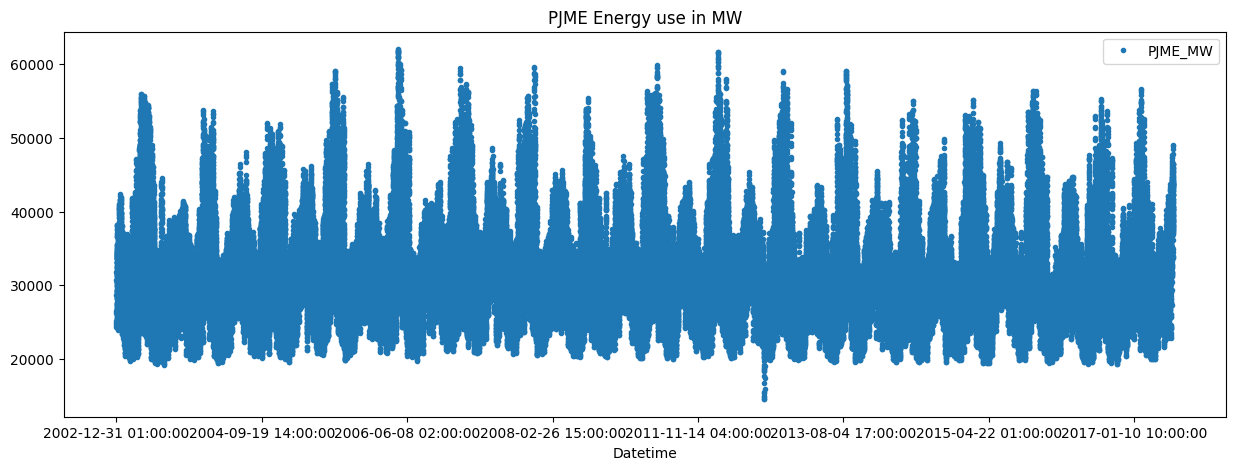

In [8]:
color_pal = plt.cm.tab10.colors

# Plot
ax=df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy use in MW')
plt.show()
df.index = pd.to_datetime(df.index)

In [9]:
import matplotlib.dates as mdates
df.index = pd.to_datetime(df.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

# Train/Test Split


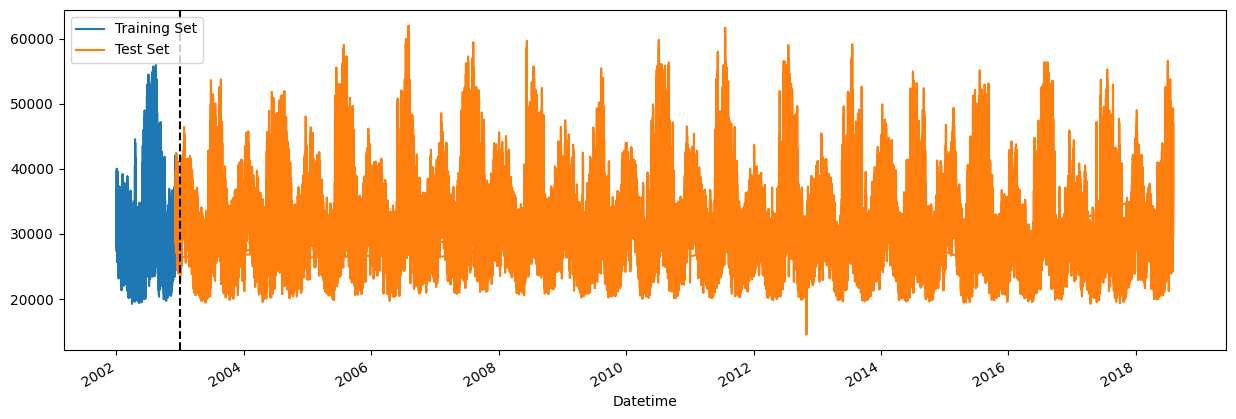

In [16]:
train = df.loc[df.index< '12-31-2002']
test = df.loc[df.index>='12-06-2002']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2002-12-31', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: xlabel='Datetime'>

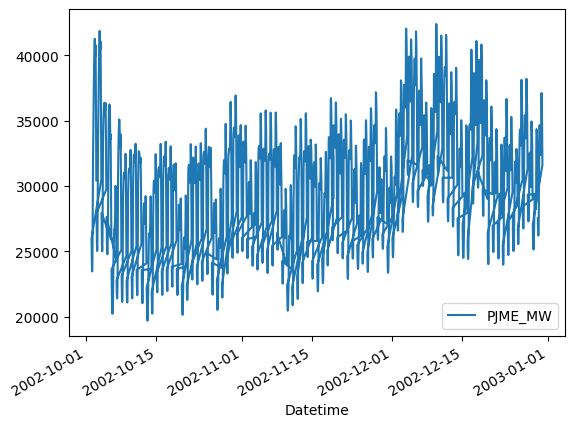

In [17]:
df.loc[(df.index>'2002-10-02') & (df.index<'2002-12-31')].plot()

#Feature creation

In [18]:
def create_features(df):

    """
    Create time series features based on time series index.
    """
    df['hour']= df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

#Visualize our Feature/Target Relationship


Text(0.5, 1.0, 'MW by Hour')

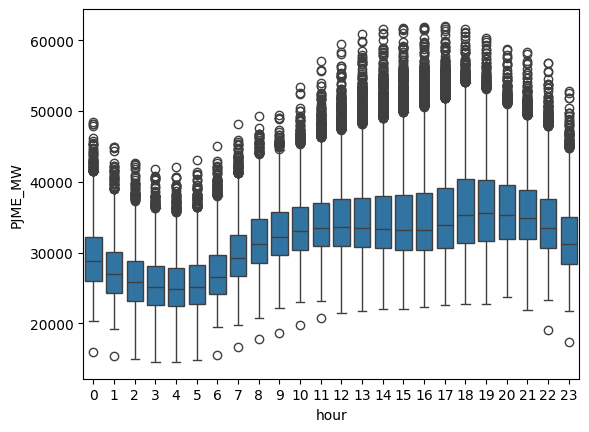

In [19]:
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')

#Create our Model

In [20]:
train=create_features(train)
test=create_features(test)
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

C:\Users\HP\AppData\Local\Temp\ipykernel_14196\968939591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour']= df.index.hour
C:\Users\HP\AppData\Local\Temp\ipykernel_14196\968939591.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
C:\Users\HP\AppData\Local\Temp\ipykernel_14196\968939591.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [21]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [22]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds =50)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:5122.16823	validation_1-rmse:5227.35787
[55]	validation_0-rmse:732.97890	validation_1-rmse:4311.01415


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#Feature Importance

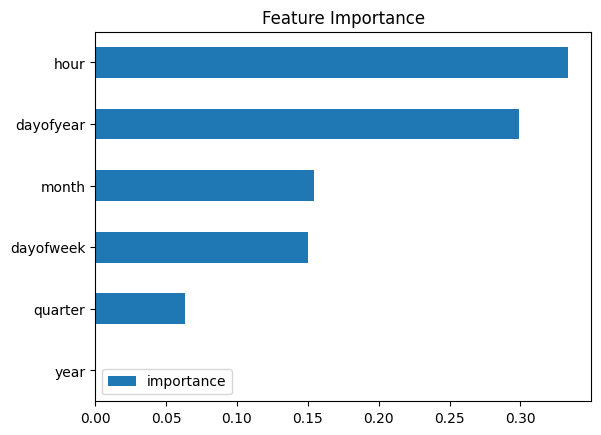

In [23]:
fi=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14196\2340650402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(x_test)


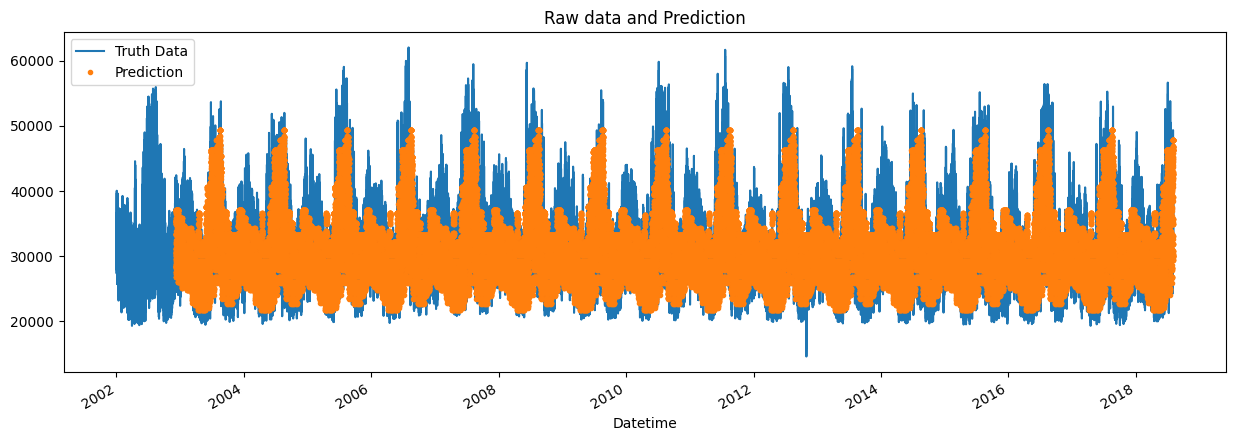

In [24]:
test['prediction'] = reg.predict(x_test)
df=df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw data and Prediction')
plt.show()


<Axes: xlabel='Datetime'>

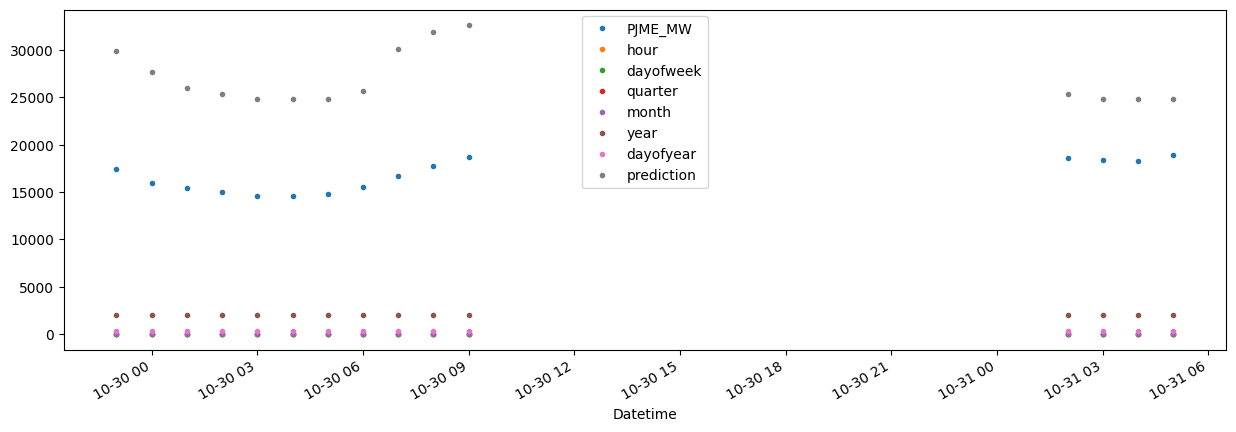

In [25]:
df.query('PJME_MW<19000').plot(figsize=(15,5),style='.')

In [26]:
df=df.query('PJME_MW>19000').copy()

#1.Time Series Cross Validation

In [27]:
from sklearn.model_selection import TimeSeriesSplit

In [28]:
tss=TimeSeriesSplit(n_splits=5,test_size=24*365*1, gap=24)
df=df.sort_index()

In [29]:
for train_idx, val_idx in tss.split(df):
    break

In [30]:
train_idx

array([     0,      1,      2, ..., 101532, 101533, 101534],
      shape=(101535,))

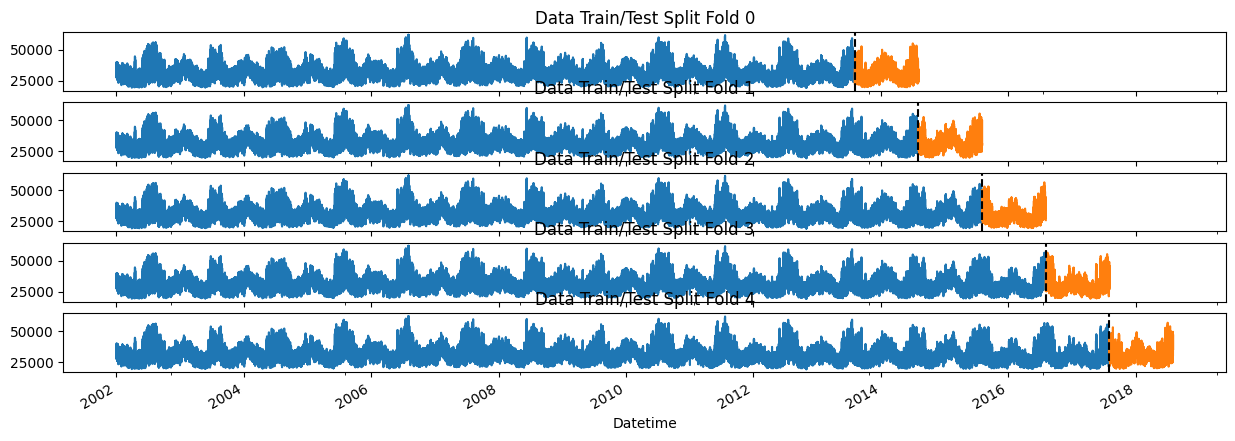

In [31]:
fig, axs = plt.subplots(5, 1, figsize=(15,5),
sharex=True)

fold=0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                        label='Trianing Set',
                           title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                        label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1

In [32]:
def create_features(df):

    """
    Create time series features based on time series index.
    """
    df['hour']= df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# 3 Lag Features

In [38]:
def add_lags(df):
    target_map=df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    return df

In [39]:
df=add_lags(df)

In [41]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,46192.339844,42256.0,42256.0,42256.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,44404.187500,41210.0,41210.0,41210.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,43684.851562,39525.0,39525.0,39525.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,42396.304688,36490.0,36490.0,36490.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,35668.960938,33539.0,33539.0,33539.0


In [ ]:
tss=TimeSeriesSplit(n_splits=5,test_size=24*365*1, gap=24)
df=df.sort_index()

fold=0
preds=[]
score=[]
for train_idx,val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    